In [76]:
!pip install google-play-scraper

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from google_play_scraper import reviews, Sort
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from matplotlib.ticker import ScalarFormatter
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [79]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
app_id = 'com.spotify.music'

result, _ = reviews(
    app_id,
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    count=2000
)

In [81]:
# Buat DataFrame
df = pd.DataFrame(result)
df = df[['content', 'score', 'at']]
df.columns = ['review', 'rating', 'date']

In [83]:
csv_path_spotify = '/content/drive/MyDrive/Project Data Mining/spotify_google_play_reviews.csv'

df.to_csv(csv_path_spotify, index=False)

print("Data Spotify New Berhasil Tersimpan!")
print(f"File ulasan tersimpan di: {csv_path_spotify}")

Data Spotify New Berhasil Tersimpan!
File ulasan tersimpan di: /content/drive/MyDrive/Project Data Mining/spotify_google_play_reviews.csv


**EDA**

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   review  2000 non-null   object        
 1   rating  2000 non-null   int64         
 2   date    2000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 47.0+ KB


In [136]:
df = df.replace('?', np.nan)
df = df.dropna(subset=['review'])

In [137]:
df.isnull().sum()

,0
review,0
rating,0
date,0
day,0
sentiment,0
clean_review,0


In [138]:
df.nunique()

,0
review,1671
rating,5
date,1996
day,12
sentiment,3
clean_review,1595


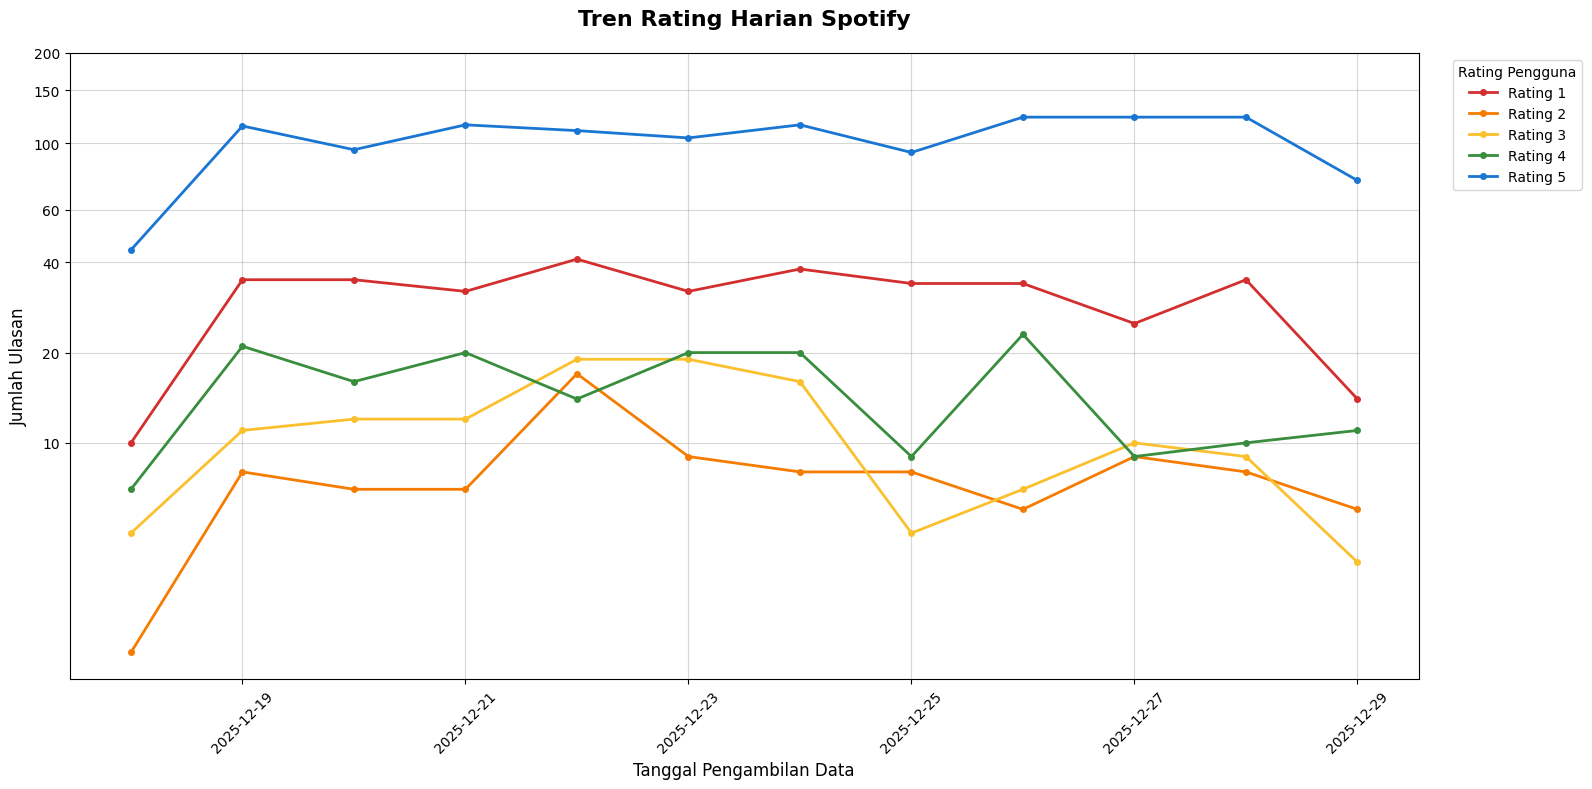

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.date

rating_trend_daily = (
    df.groupby(["day", "rating"])
    .size()
    .reset_index(name="count")
)

all_ratings = sorted(df['rating'].unique())

plt.figure(figsize=(16, 8))

colors = ['#d32f2f', '#f57c00', '#fbc02d', '#388e3c', '#1976d2']

for i, r in enumerate(all_ratings):
    data_plot = rating_trend_daily[rating_trend_daily["rating"] == r]
    plt.plot(data_plot["day"], data_plot["count"],
             marker='.', markersize=8, linestyle='-',
             linewidth=2, label=f"Rating {r}", color=colors[i])

plt.yscale('symlog')
plt.gca().yaxis.set_major_formatter(ScalarFormatter())

plt.yticks([10, 20, 40, 60, 100, 150, 200])

plt.title("Tren Rating Harian Spotify", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Tanggal Pengambilan Data", fontsize=12)
plt.ylabel("Jumlah Ulasan", fontsize=12)

plt.xticks(rotation=45)

plt.legend(title="Rating Pengguna", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True)

plt.grid(True, which="both", linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

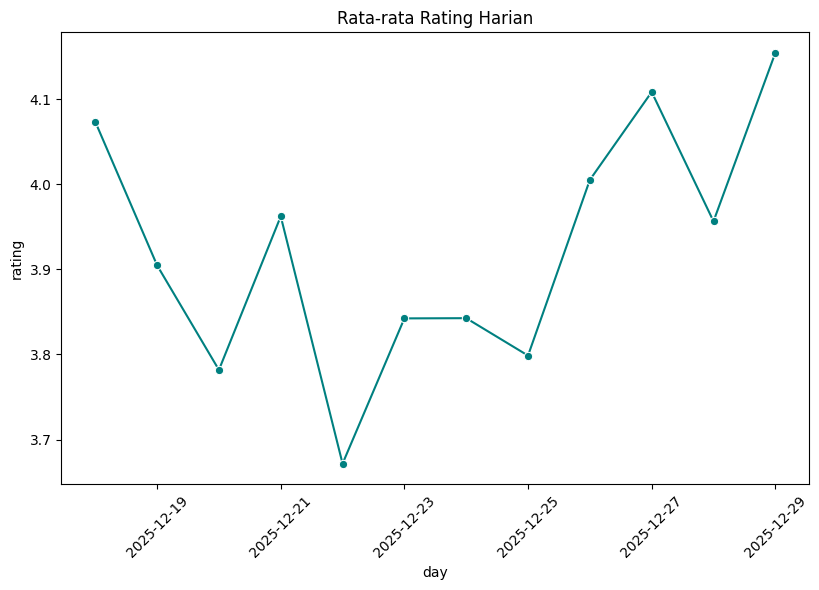

In [164]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
daily_rating_mean = df.groupby("day")["rating"].mean().reset_index()
sns.lineplot(data=daily_rating_mean, x="day", y="rating", marker='o', color='teal')
plt.title("Rata-rata Rating Harian")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

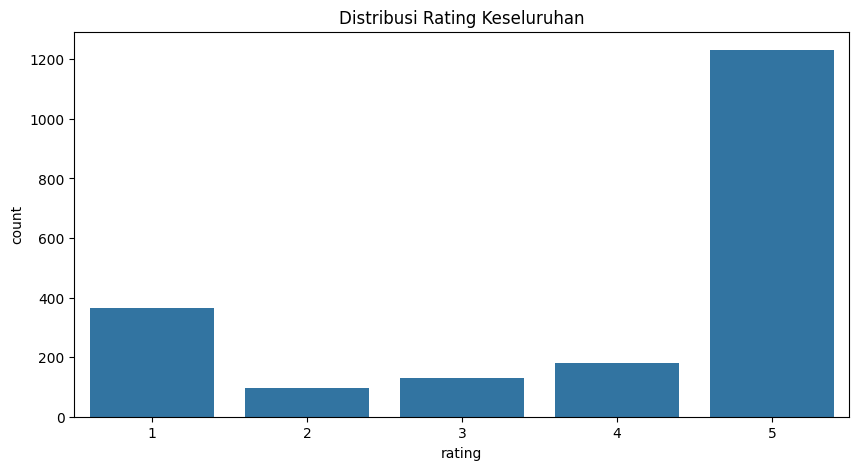

In [158]:
plt.figure(figsize=(10, 5))
sns.countplot(x='rating', data=df)
plt.title('Distribusi Rating Keseluruhan')
plt.show()

DATA **PREPROCESSING**

In [142]:
def label_sentiment(rating):
    if rating >= 4:
        return 'positif'
    elif rating <= 2:
        return 'negatif'
    else:
        return 'netral'

df['sentiment'] = df['rating'].apply(label_sentiment)
df.head()

,review,rating,date,day,sentiment,clean_review
0,maaf ya .untuk lagu banyak yang gak keluar pas...,4,2025-12-29 11:47:19,2025-12-29,positif,maaf ya lagu gak pas disearch
1,sangat suka,5,2025-12-29 11:37:26,2025-12-29,positif,suka
2,iklannya ga benget sumpahhhh abis muter 2 lagu...,1,2025-12-29 11:23:37,2025-12-29,negatif,iklannya ga benget sumpahhhh abis muter lagu l...
3,mantap,5,2025-12-29 11:10:09,2025-12-29,positif,mantap
4,bagus sekali,5,2025-12-29 11:05:28,2025-12-29,positif,bagus


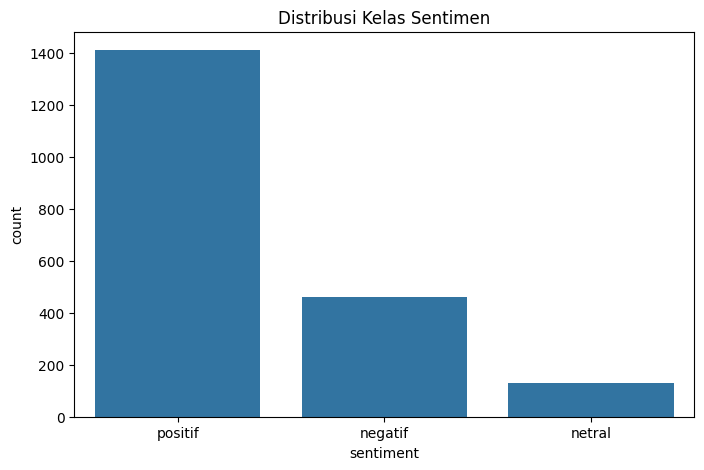

In [143]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df)
plt.title('Distribusi Kelas Sentimen')
plt.show()

In [144]:
stop_words = set(stopwords.words('indonesian'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].head()

,review,clean_review
0,maaf ya .untuk lagu banyak yang gak keluar pas...,maaf ya lagu gak pas disearch
1,sangat suka,suka
2,iklannya ga benget sumpahhhh abis muter 2 lagu...,iklannya ga benget sumpahhhh abis muter lagu l...
3,mantap,mantap
4,bagus sekali,bagus


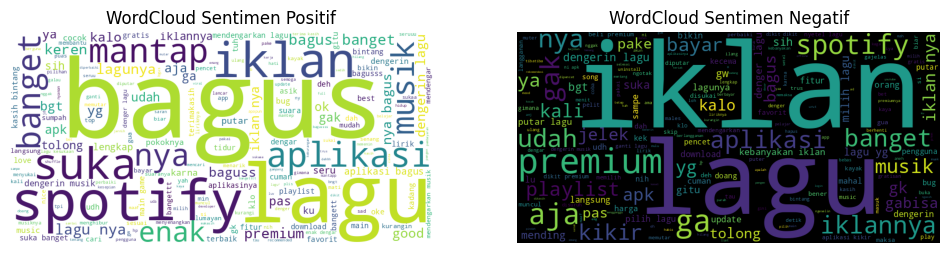

In [145]:
positive_text = ' '.join(df[df['sentiment'] == 'positif']['clean_review'])
negative_text = ' '.join(df[df['sentiment'] == 'negatif']['clean_review'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.title('WordCloud Sentimen Positif')

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.title('WordCloud Sentimen Negatif')
plt.show()

**NaiveBayes**

In [146]:
X = df['clean_review']
y = df['sentiment']

In [147]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

In [149]:
y_train.value_counts()

,count
sentiment,
positif,1111
negatif,376
netral,113


In [150]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [151]:
y_train_smote.value_counts()

,count
sentiment,
positif,1111
negatif,1111
netral,1111


In [152]:
nb = MultinomialNB()
nb.fit(X_train_smote, y_train_smote)

MultinomialNB()

In [160]:
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     negatif       0.64      0.75      0.69        84
      netral       0.09      0.38      0.15        16
     positif       0.98      0.78      0.87       300

    accuracy                           0.76       400
   macro avg       0.57      0.63      0.57       400
weighted avg       0.87      0.76      0.80       400



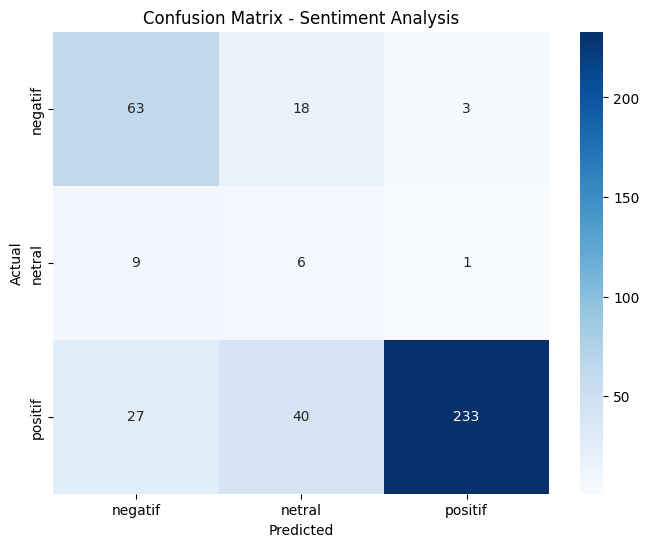

In [154]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb.classes_,
            yticklabels=nb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Sentiment Analysis')
plt.show()